In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [34]:
# replace with the actual CSV file path or URL
df = pd.read_csv('data/bug-severity-raw.csv')
df.head()

,ticket_id,submitted_at,product_area,customer_type,priority,reporter_experience,reproduction_steps,num_attachments,description_length,affected_users_count,prev_similar_tickets,module_version,ticket_type,auto_tag_count,sla_breached,assigned_team,severity,resolved_at
0,TCKT-100000,9/29/2023 13:35,Auth,Internal,Medium,Senior,True,1,574.0,13.0,0.0,5.2.11,Bug,5,No,QA,Medium,9/30/2023 19:35
1,TCKT-100001,3/5/2025 6:23,DevOps,Internal,High,Junior,True,0,299.0,16.0,2.0,4.2.4,Question,3,Yes,Dev,Medium,3/6/2025 16:23
2,TCKT-100002,7/25/2023 18:40,ML,SMB,Low,Junior,False,2,526.0,13.0,0.0,3.2.11,Bug,1,No,QA,Low,7/27/2023 2:40
3,TCKT-100003,10/18/2023 22:03,Auth,Free-tier,Low,Mid,True,2,734.0,7.0,0.0,4.8.4,Bug,2,No,QA,Low,10/20/2023 3:03
4,TCKT-100004,6/27/2025 0:35,Backend,Enterprise,medium,Mid,True,1,374.0,7.0,3.0,2.9.15,Bug,3,No,Security,Medium,6/27/2025 7:35


In [35]:
df.shape

(5000, 18)

### Data checks

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ticket_id             5000 non-null   object 
 1   submitted_at          5000 non-null   object 
 2   product_area          5000 non-null   object 
 3   customer_type         5000 non-null   object 
 4   priority              5000 non-null   object 
 5   reporter_experience   5000 non-null   object 
 6   reproduction_steps    5000 non-null   bool   
 7   num_attachments       5000 non-null   int64  
 8   description_length    4750 non-null   float64
 9   affected_users_count  4752 non-null   float64
 10  prev_similar_tickets  4750 non-null   float64
 11  module_version        5000 non-null   object 
 12  ticket_type           5000 non-null   object 
 13  auto_tag_count        5000 non-null   int64  
 14  sla_breached          5000 non-null   object 
 15  assigned_team        

In [75]:
df.describe()

,submitted_at,num_attachments,description_length,affected_users_count,prev_similar_tickets,auto_tag_count,resolved_at,hour_of_day,days_to_resolve
count,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000,5000.000000,5000.000000
mean,2024-04-02 06:42:56.292000,1.520600,597.502000,42.457912,0.953000,1.981800,2024-04-03 00:52:07.811999744,11.470400,0.306400
min,2023-01-01 09:38:00,0.000000,70.000000,1.000000,0.000000,0.000000,2023-01-01 16:30:00,0.000000,-1.000000
25%,2023-08-19 20:30:45,0.000000,501.000000,8.000000,0.000000,1.000000,2023-08-20 07:59:00,5.000000,0.000000
50%,2024-04-02 17:36:30,1.000000,597.000000,10.000000,1.000000,2.000000,2024-04-03 11:33:00,11.000000,0.000000
75%,2024-11-17 18:57:45,2.000000,697.000000,13.000000,2.000000,3.000000,2024-11-18 08:43:15,17.250000,1.000000
max,2025-06-30 22:09:00,48.000000,1153.000000,4932.000000,6.000000,10.000000,2025-07-02 11:09:00,23.000000,1.000000
std,NaN,3.494742,147.545576,326.820931,0.985386,1.416429,NaN,6.938844,0.471766


In [37]:
# check for missing values
df.isnull().sum()

ticket_id                 0
submitted_at              0
product_area              0
customer_type             0
priority                  0
reporter_experience       0
reproduction_steps        0
num_attachments           0
description_length      250
affected_users_count    248
prev_similar_tickets    250
module_version            0
ticket_type               0
auto_tag_count            0
sla_breached              0
assigned_team             0
severity                  0
resolved_at               0
dtype: int64

In [38]:
# Fix missing values through statistical imputation
df['description_length']=df['description_length'].fillna(df['description_length'].median())
df['affected_users_count']=df['affected_users_count'].fillna(df['affected_users_count'].mean())
df['prev_similar_tickets']=df['prev_similar_tickets'].fillna(0)

In [39]:
# Checking for incinsistent formating issues in product area
df['product_area'].unique()

array(['Auth', 'DevOps', 'ML', 'Backend', 'Security', 'API', 'Database',
       'UI'], dtype=object)

In [40]:
# Checking for inconsistent formatting issues in customer type 
df['customer_type'].unique()

array(['Internal', 'SMB', 'Free-tier', 'Enterprise', 'smb'], dtype=object)

In [41]:
# convert smb to title case for consistency
df['customer_type']=df['customer_type'].str.title()

In [42]:
df['priority'].unique()

array(['Medium', 'High', 'Low', 'medium', 'Urgent', 'urgent', 'high'],
      dtype=object)

In [43]:
# convert to title case for consistency
df['priority']=df['priority'].str.title()

In [44]:
df['reporter_experience'].unique()

array(['Senior', 'Junior', 'Mid', 'mid', 'senior', 'junior'], dtype=object)

In [45]:
# convert to title case for consistency
df['reporter_experience']=df['reporter_experience'].str.title()

In [47]:
df['ticket_type'].unique()

array(['Bug', 'Question', 'crash', 'Crash', 'Performance',
       'Feature Request', 'bug'], dtype=object)

In [48]:
# convert to title case for consistency
df['ticket_type']=df['ticket_type'].str.title()

In [49]:
df['assigned_team'].unique()

array(['QA', 'Dev', 'Security', 'SRE', 'Support', 'support'], dtype=object)

In [50]:
# convert to title case for consistency
df['assigned_team']=df['assigned_team'].str.title()

In [51]:
df['severity'].unique()

array(['Medium', 'Low', 'High', 'Critical', 'critical'], dtype=object)

In [52]:
# convert to title case for consistency
df['severity']=df['severity'].str.title()

In [64]:
# Convert dates to datetime format
df['submitted_at']=pd.to_datetime(df['submitted_at'])
df['resolved_at']=pd.to_datetime(df['resolved_at'])

# Extract useful features from datetime columns
df['day_of_week']=df['submitted_at'].dt.day_name()
df['hour_of_day']=df['submitted_at'].dt.hour
df['month_year']=df['submitted_at'].dt.to_period('M').astype(str)
df['days_to_resolve']=(df['resolved_at'] - df['submitted_at']).dt.days

In [65]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

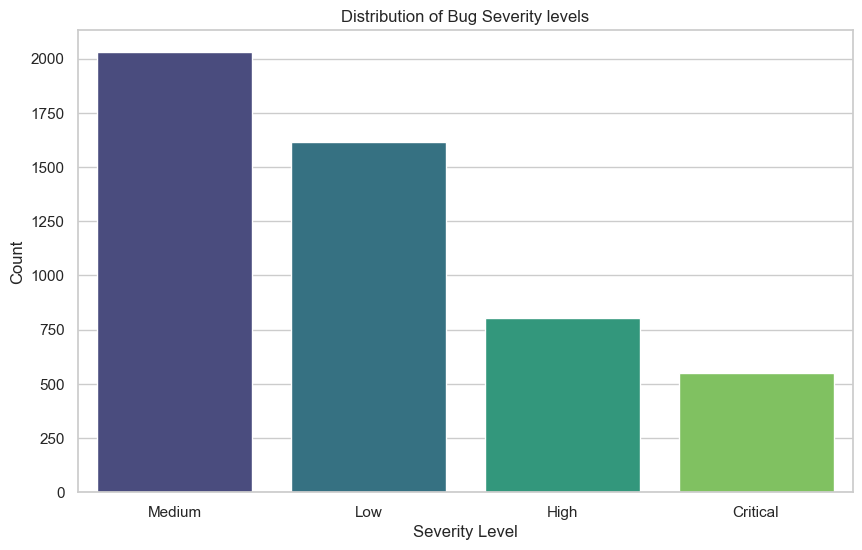

In [66]:
# Visualizing the balance of the target variable
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='severity', palette='viridis')
plt.title('Distribution of Bug Severity levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='severity', ylabel='description_length'>

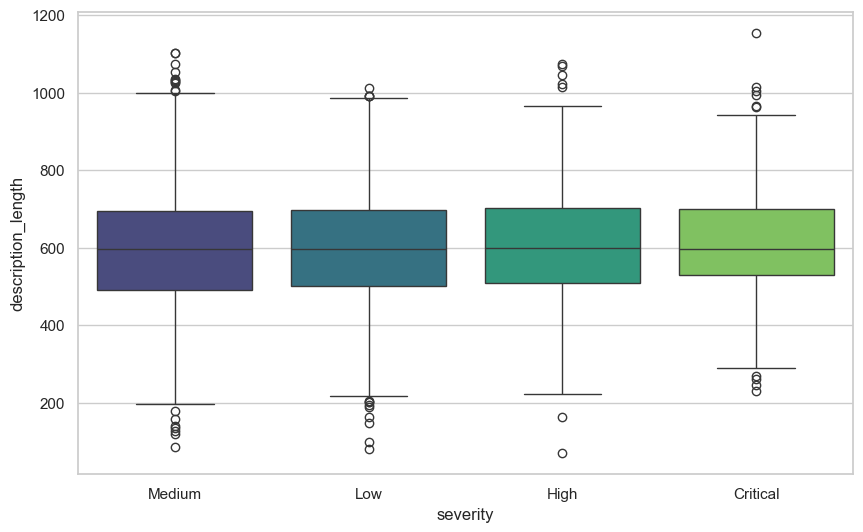

In [67]:
# Check for the relationship between description in length and severity
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='severity', y='description_length', palette="viridis")

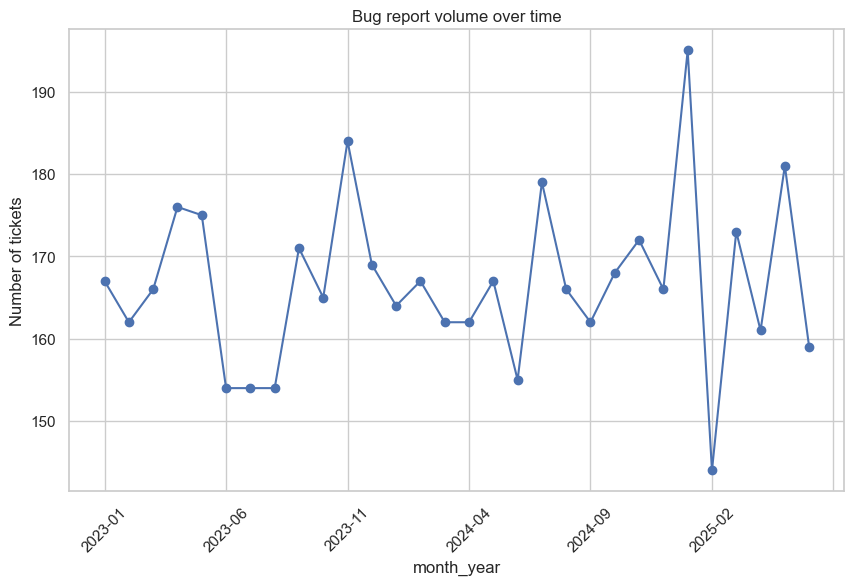

In [68]:
# Visualizing gug report volume over time
plt.figure(figsize=(10,6))
df.groupby('month_year').size().plot(kind='line',marker='o')
plt.title('Bug report volume over time')
plt.xticks(rotation=45)
plt.ylabel('Number of tickets')
plt.show()

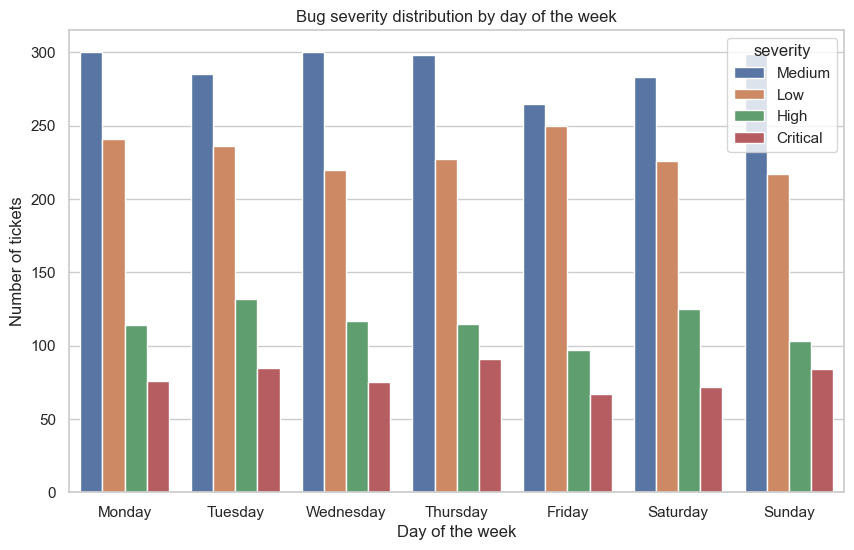

In [69]:
# Day of the week analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='day_of_week', order=day_order, hue='severity')
plt.title('Bug severity distribution by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Number of tickets')
plt.show()

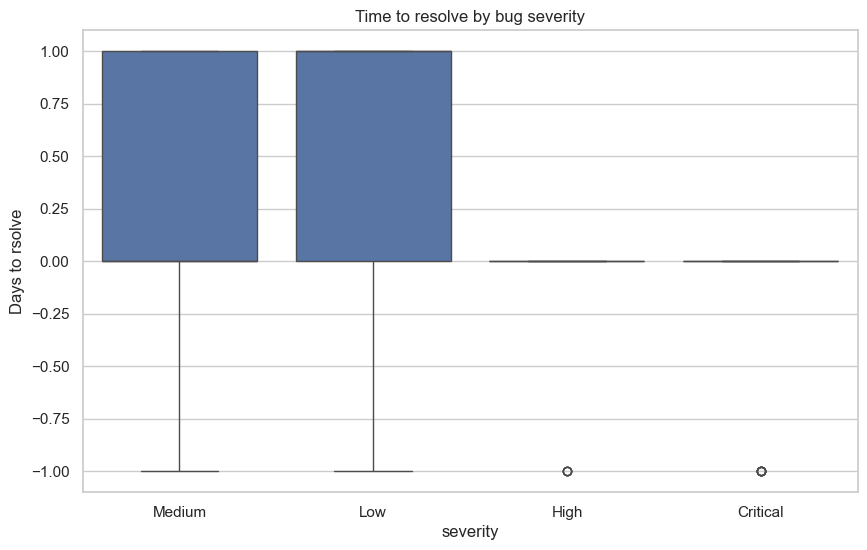

In [72]:
# Visualization of resolution efficiency
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='severity', y='days_to_resolve')
plt.title('Time to resolve by bug severity')
plt.ylabel('Days to rsolve')
plt.show()

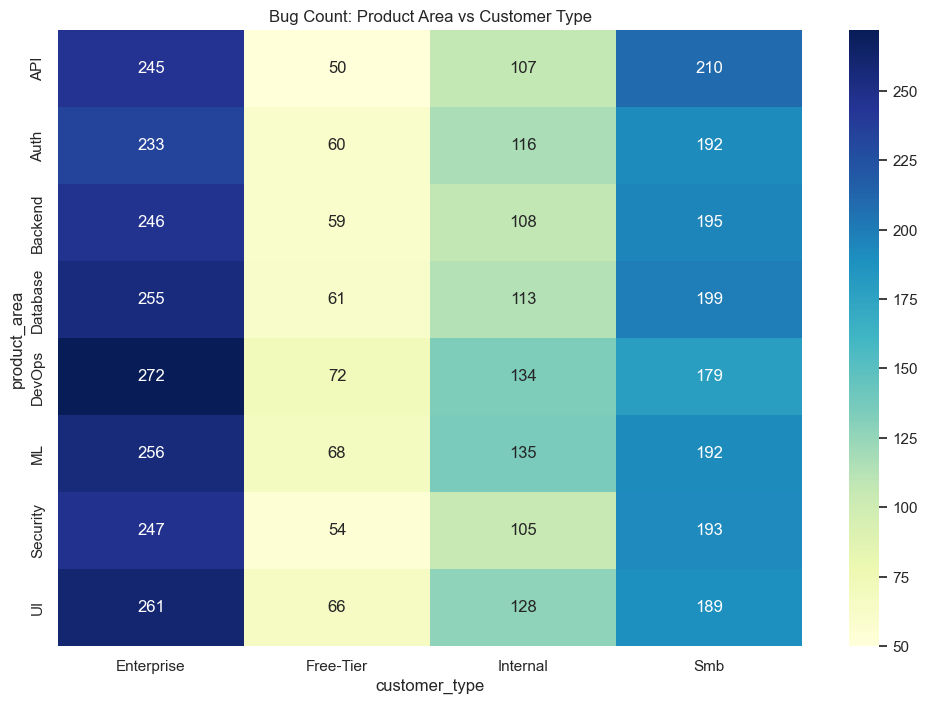

In [74]:
# Product heatmap visualization
ct = pd.crosstab(df['product_area'], df['customer_type'])
plt.figure(figsize=(12,8))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Bug Count: Product Area vs Customer Type')
plt.show()